In [1]:
import sys; sys.path.insert(0, '../../'); sys.path.insert(0,'../mupClassification/')
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from matplotlib.pylab import *
import matplotlib.patches as patches
%matplotlib inline

OffBeam_scaling: 1.24224698773 = N(on beam)/N(off beam) before sof. trig.
MC_scaling: 0.504451038576 = N(POT on beam)/N(POT MC)


# 1.III The distribution of On-Off beam before any acceptance cuts
Sep-3, 2017

In [2]:
debug = 1
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/DistributionsBeforeCuts/'

In [3]:
Nevents

{'MC-BNB/Cosmic-DATA overlay': 96350,
 'MC-BNB/Cosmic-DATA overlay POT': 9.773e+19,
 'OffBeam after sof.trig.': 380602,
 'OffBeam before sof.trig.': 8529852.084267145,
 'OffBeam sof.trig. efficiency': 0.04462,
 'OnBeam POT': 4.93e+19,
 'OnBeam after sof.trig.': 544114,
 'OnBeam before sof.trig.': 10596183.05744888,
 'OnBeam sof.trig. efficiency': 0.05135,
 'v04 after sof.trig.': 378787,
 'v05 after sof.trig.': 1815}

## (1) Off-Beam from two samples
the infamous "inconsistent process history" issue
separate the list into two lists 
corresponding to files that were swizzled using v04_26_04_% and v05_08_00_%

In [4]:
OffBeam = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco2_extbnb_v8_mcc8_vertices.csv')
OffBeamFV = sample_in_FV(OffBeam)
print len(OffBeam),'pairs from Off-Beam'
print len(OffBeamFV),'pairs from Off-Beam in FV'

108434 pairs from Off-Beam
66567 pairs from Off-Beam in FV


## (2) On-Beam sample

In [5]:
OnBeam = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prod_reco2_bnb_v8_mcc8_vertices.csv')
OnBeamFV = sample_in_FV(OnBeam)
print len(OnBeam),'pairs from On-Beam'
print len(OnBeamFV),'pairs from On-Beam in FV'

162345 pairs from On-Beam
100560 pairs from On-Beam in FV


## (3) MC-BNB + Cosmic DATA overlay 

In [6]:
pairsFV, MCsamples = load_pairs_as_samples()
pur_eff,pur_eff_numbers = apply_cuts()

50939 pairs from MC-BNB + cosmic DATA overlay
30377 pairs in FV
3814 are 1mu-1p, 12.6%
4001 are other pairs, 13.2%
22562 are cosmic, 74.3%
--------------------------------------------------------------
1234 are CC 1p 0pi, 4.1%


# Plots

In [7]:
def OnBeam_minus_OffBeam_1d( OnBeamSample=OnBeamFV , OffBeamSample=OffBeamFV 
                            , var='PIDa_assigned_proton' , x_label='$PID_a^p$' 
                            , bins=np.linspace(0,30,31) 
                            , ax=None, figsize=(14,6),fontsize=25
                            , color='purple'
                            , do_add_MCoverlay=True 
                            , do_add_legend=True , legend_loc='best', MCalpha=0.5):
    bin_width = bins[1]-bins[0]
    if ax is None: fig,ax=plt.subplots(figsize=figsize)
    h_OnBeam,edges = np.histogram( OnBeamSample[var] , bins=bins )
    h_OnBeam_err = np.sqrt(h_OnBeam)
    h_OffBeam,edges = np.histogram( OffBeamSample[var] , bins=bins )
    h_OffBeam_err = np.sqrt(h_OffBeam)
    
    h_OnBeam_minus_OffBeam = h_OnBeam - OffBeam_scaling*h_OffBeam
    h_OnBeam_minus_OffBeam_err = np.sqrt( np.square(h_OnBeam_err) + np.square(OffBeam_scaling*h_OffBeam_err)  )
    
    plt.errorbar( x = bins[:-1], xerr=bin_width/2.
                 , y=h_OnBeam_minus_OffBeam , yerr=h_OnBeam_minus_OffBeam_err
                 , fmt='o', color=color , ecolor='black', label='(On-Off) Beam'
                )
    ax.set_xlim(np.min(bins)-bin_width,np.max(bins)+bin_width);
    ax.set_ylim(np.min([0,np.min(h_OnBeam_minus_OffBeam-1.1*h_OnBeam_minus_OffBeam_err)])
                ,np.max(h_OnBeam_minus_OffBeam+1.1*h_OnBeam_minus_OffBeam_err));

    plt.plot(ax.get_xlim(),[0,0],'--',color='black',linewidth=2)
    set_axes(ax,x_label=x_label,y_label='counts',do_add_grid=True,fontsize=fontsize)
    
    if do_add_MCoverlay:        
        N_OnBeam_minus_OffBeam = len(OnBeamSample) - OffBeam_scaling*len(OffBeamSample)
        if debug: print 'Number of On-Off:',N_OnBeam_minus_OffBeam

        plot_stacked_MCsamples( ax=ax
                               , MCsamples = MCsamples , var=var, bins=bins 
                               , N_OnBeam_minus_OffBeam=N_OnBeam_minus_OffBeam , alpha=MCalpha)
    
    if do_add_legend: 
        plt.legend(fontsize=fontsize,loc=legend_loc)
    
    
def OnBeam_minus_OffBeam_2d( OnBeamSample=OnBeamFV , OffBeamSample=OffBeamFV 
                            , varx='l_assigned_proton' , x_label='$l^{\\mu}$' 
                            , vary='l_assigned_muon' , y_label='$l^p$' 
                            , bins=(np.linspace(0,100,51),np.linspace(0,150,51))
                            , ax=None, figsize=(12,8),fontsize=25
                            , cmap='hot_r'):
    if ax is None: fig,ax=plt.subplots(figsize=figsize)
    h_OnBeam_T,xedges, yedges = np.histogram2d( OnBeamSample[varx] , OnBeamSample[vary] , bins=bins )
    h_OffBeam_T,xedges, yedges = np.histogram2d( OffBeamSample[varx] , OffBeamSample[vary] , bins=bins )
    
    h_OnBeam_minus_OffBeam_T = h_OnBeam_T - OffBeam_scaling*h_OffBeam_T
    h_OnBeam_minus_OffBeam = h_OnBeam_minus_OffBeam_T.T

    X, Y = np.meshgrid(xedges, yedges)
    pcmesh = ax.pcolormesh(X, Y, h_OnBeam_minus_OffBeam ,cmap=cmap)
    cbar = plt.colorbar(pcmesh,label='(On-Off) Beam [cts]')
    cbar.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=fontsize))
    cbar.ax.tick_params(labelsize=fontsize) 
    
    bin_width = [bins[0][1]-bins[0][0],bins[1][1]-bins[1][0]]    
    ax.set_xlim(np.min(bins[0])-bin_width[0],np.max(bins[0])+bin_width[0]);
    ax.set_ylim(np.min(bins[1])-bin_width[1],np.max(bins[1])+bin_width[1]);
    set_axes(ax,x_label=x_label,y_label=y_label,do_add_grid=True,fontsize=fontsize)

In [18]:
def plot_stacked_MCsamples( ax=None, MCsamples = MCsamples 
                           , var=None, bins=None , N_OnBeam_minus_OffBeam=1, alpha=0.8):
    Nall_pairs = len(MCsamples['1mu-1p']+MCsamples['cosmic']+MCsamples['other pairs'])
#     MC_norm_fact = N_OnBeam_minus_OffBeam/Nall_pairs

    x_array, weights_array = [] , []
    label_array , color_array = [] , []
    # stack background (cosmic, other-pairs) + 1µ1p pairs
    for i_pair_type in [2,1,0]:
        pair_type=pair_types[i_pair_type]
        sample = MCsamples[pair_type]; 
        label_array.append(MClabels[i_pair_type]); 
        color_array.append(MCcolors[i_pair_type]);
        x = sample[var]
        x_array.append(x)
        # normalize the MC to have the same number of events as the total On-Off beam sample
        weights_array.append (MC_scaling * np.ones(len(x)) )
        # -- - - - --------- - - -- ---- -  - --- -- -- -- --
    bin_width = bins[1]-bins[0]
    h,bins_arr,_=ax.hist( x_array , weights=weights_array
                     , bins=bins-0.5*bin_width, width=bin_width
                     , stacked=True 
                     , color=color_array
                     , label=label_array
                     , alpha=alpha)            
    h_stack = h[0]+h[1]+h[2]
    if np.max(h[2])>np.max(ax.get_ylim()):
        ax.set_ylim(np.min(ax.get_ylim()),1.05*np.max(h[2]))
        
    # add CC1p0π as a box inside the 1µ1p 
    sample = MCsamples[pair_types[3]]
    hCC1p0pi,edges = np.histogram( sample[var] , weights=MC_scaling*np.ones(len(sample)) , bins=bins )
    for bin in range(len(bins[:-2])):
        x, dx = bins[bin+1] - 0.4*bin_width, bin_width 
        y, dy = 0.99*h[2][bin+1] - hCC1p0pi[bin], hCC1p0pi[bin]
        ax.add_patch( patches.Rectangle( (x, y),dx,dy, facecolor=MCcolors[3],alpha=0.8*alpha,label=MClabels[3] if bin==0 else None))

# lets get to buissiness

Number of On-Off: 17867.3447679


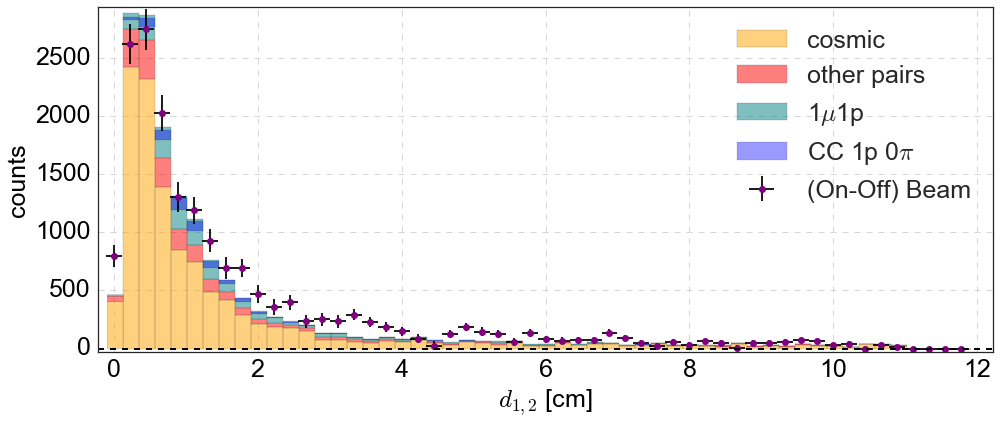

In [19]:
OnBeam_minus_OffBeam_1d(var='distance' , x_label='$d_{1,2}$ [cm]', bins=np.linspace(0,12,55) , MCalpha=0.5)
plt.tight_layout()
plt.savefig(figures_path+'distance_no_cuts'+'.pdf')

Number of On-Off: 17867.3447679
Number of On-Off: 17867.3447679


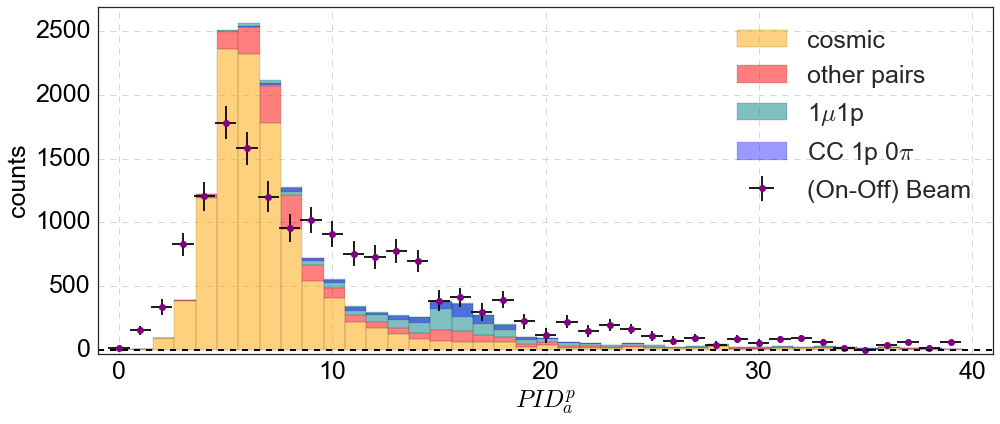

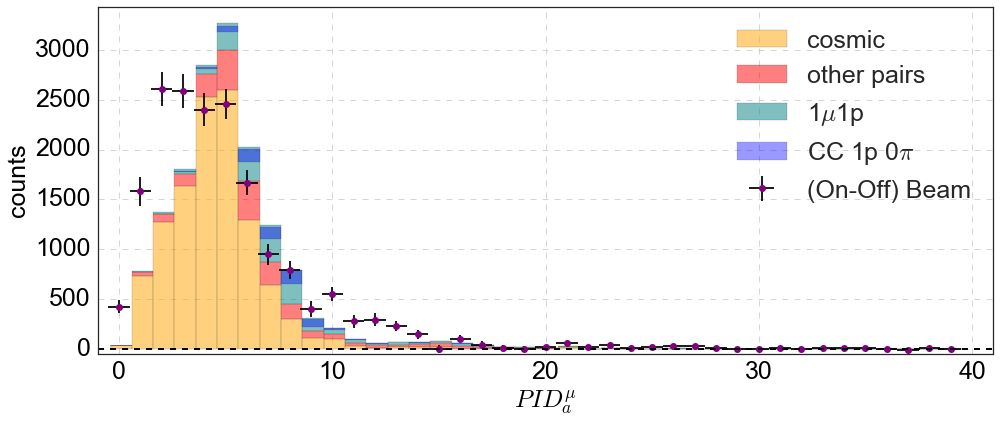

In [20]:
OnBeam_minus_OffBeam_1d(var='PIDa_assigned_proton' , x_label='$PID_a^p$', bins=np.linspace(0,40,41) , MCalpha=0.5 )
plt.tight_layout()
plt.savefig(figures_path+'PIDa_p_no_cuts'+'.pdf')
OnBeam_minus_OffBeam_1d(var='PIDa_assigned_muon' , x_label='$PID_a^{\\mu}$', bins=np.linspace(0,40,41) , MCalpha=0.5 )
plt.tight_layout()
plt.savefig(figures_path+'PIDa_mu_no_cuts'+'.pdf')

Number of On-Off: 17867.3447679
Number of On-Off: 17867.3447679


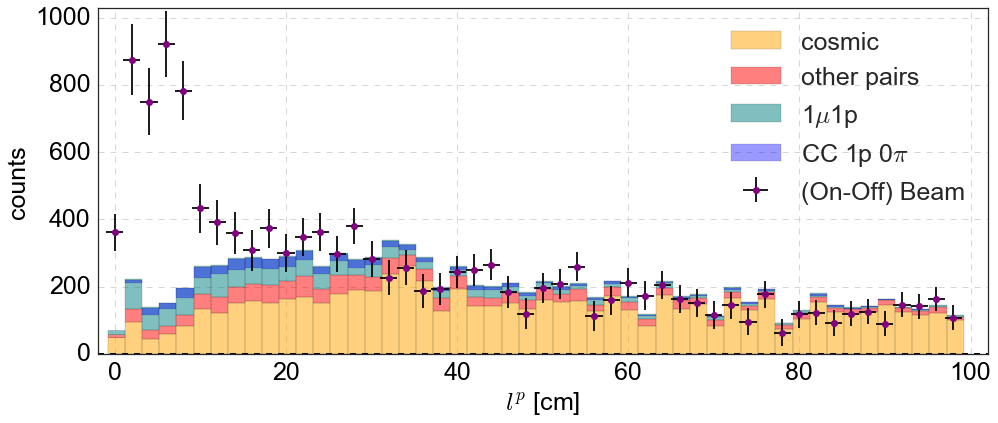

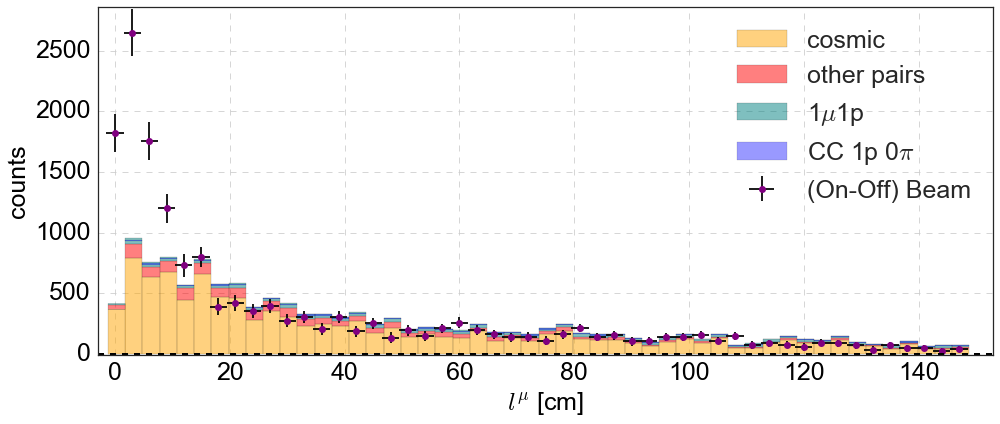

In [21]:
OnBeam_minus_OffBeam_1d(var='l_assigned_proton' , x_label='$l^{p}$ [cm]', bins=np.linspace(0,100,51))
plt.tight_layout()
plt.savefig(figures_path+'l_p_no_cuts'+'.pdf')
OnBeam_minus_OffBeam_1d(var='l_assigned_muon' , x_label='$l^{\\mu}$ [cm]', bins=np.linspace(0,150,51))
plt.tight_layout()
plt.savefig(figures_path+'l_mu_no_cuts'+'.pdf')

Number of On-Off: 17867.3447679


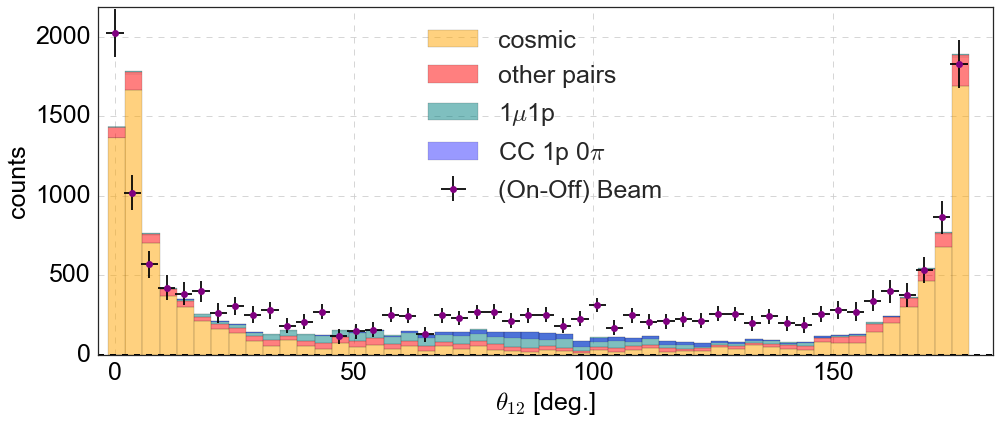

In [22]:
OnBeam_minus_OffBeam_1d(var='theta_12' , x_label='$\\theta_{12}$ [deg.]', bins=np.linspace(0,180,51))
plt.tight_layout()
plt.savefig(figures_path+'theta_12_no_cuts'+'.pdf')

Number of On-Off: 17867.3447679


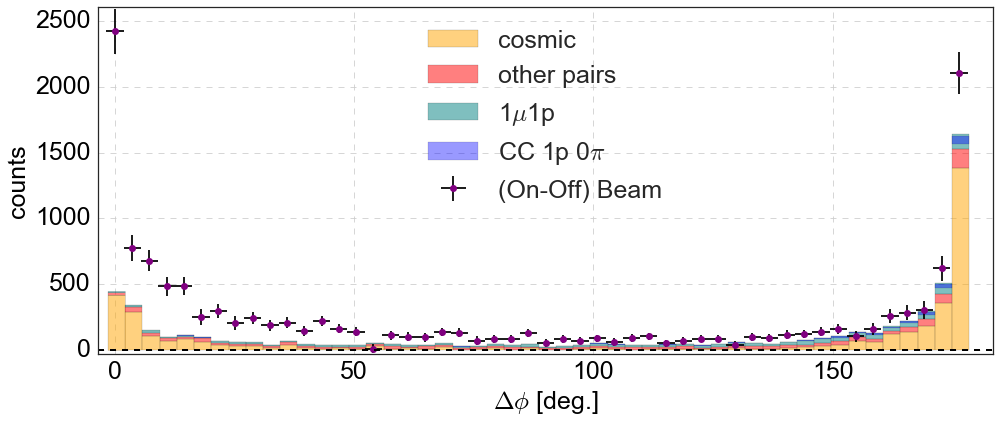

In [23]:
OnBeam_minus_OffBeam_1d(var='delta_phi' , x_label='$\\Delta \\phi$ [deg.]', bins=np.linspace(0,180,51))
plt.tight_layout()
plt.savefig(figures_path+'delta_phi_no_cuts'+'.pdf')

Number of On-Off: 17867.3447679


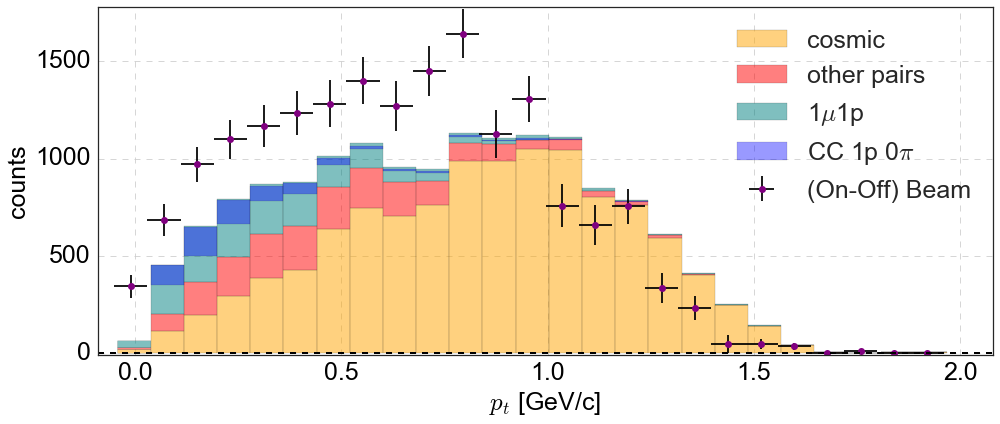

In [24]:
OnBeam_minus_OffBeam_1d(var='reco_Pt' , x_label='$p_{t}$ [GeV/c]', bins=np.linspace(-0.01,2,26))
plt.tight_layout()
plt.savefig(figures_path+'Pt_no_cuts'+'.pdf')

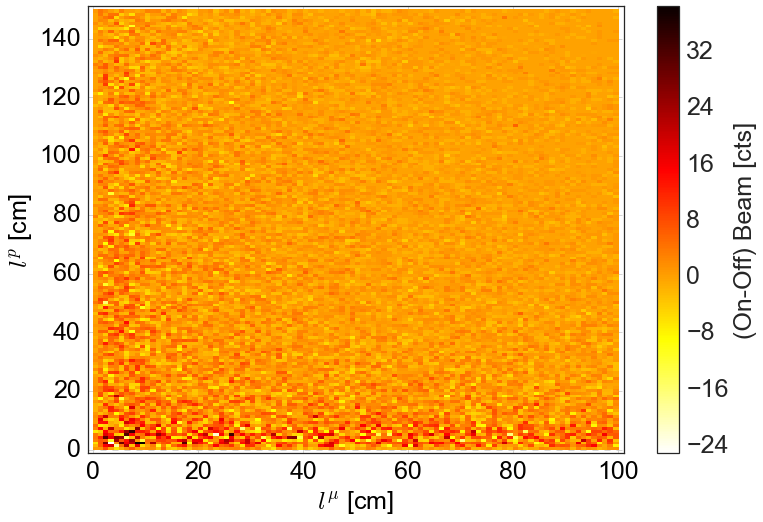

In [25]:
OnBeam_minus_OffBeam_2d( varx='l_assigned_proton' , x_label='$l^{\\mu}$ [cm]'                             
                        , vary='l_assigned_muon' , y_label='$l^p$ [cm]'
                        , bins=(np.linspace(0,100,101),np.linspace(0,150,151)))